# Задание 4. RNN & LSTM


Написать RNN и LSTM для прогнозирования Usage_kWh. Датасет - http://archive.ics.uci.edu/ml/datasets/Steel+Industry+Energy+Consumption+Dataset. Гиперпараметры на Ваше усмотрение. Сравнить качество работы обеих моделей

## Установим окружение

In [1]:
! pip install -r requirements.txt

In [2]:
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data

In [3]:
! sh download_data.sh

mkdir: cannot create directory ‘data’: File exists
--2022-05-22 14:05:33--  http://archive.ics.uci.edu/ml/machine-learning-databases/00618/Steel_industry_data.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [4]:
data = pd.read_csv('data/Steel_industry_data.csv')
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [5]:
data.describe()

,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


Надо научиться предсказывать Usage_kWh

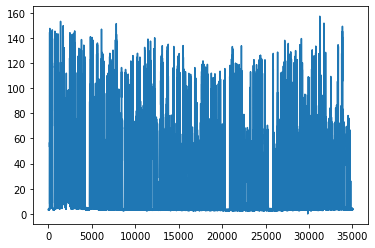

In [6]:
plt.plot(data['Usage_kWh'])

## Преобразуем данные для сети

In [7]:
data.columns[data.dtypes==object]

Index(['date', 'WeekStatus', 'Day_of_week', 'Load_Type'], dtype='object')

Заэнкодим данные типа object и преобразуем данные

In [8]:
from preprocess import preprocess_data
data = preprocess_data(data)

In [9]:
from dataset import train_val_test_split
data_train, data_val, data_test = train_val_test_split(data)

In [10]:
from dataset import cut_df_to_dataset
x_train, y_train = cut_df_to_dataset(data_train, 20, 'Usage_kWh')
x_val, y_val = cut_df_to_dataset(data_val, 20, 'Usage_kWh')
x_test, y_test = cut_df_to_dataset(data_test, 20, 'Usage_kWh')

## Modelling RNN

In [11]:
from model import setup_optimizers, RNN_Model
from optimizers import Adam
from trainer import trainer

model = RNN_Model(12, 100)
model.optim = Adam()
setup_optimizers(model)

epoch_num = 10000
learning_rate = 1e-3
trainer(x_train, y_train, x_val, y_val, epoch_num, learning_rate, model)

Epoch 0:  Train loss: 1973.02175  Val loss: 1454.40329
Epoch 25:  Train loss: 1084.21230  Val loss: 649.23659
Epoch 50:  Train loss: 633.32231  Val loss: 494.95205
Epoch 75:  Train loss: 523.75095  Val loss: 405.04362
Epoch 100:  Train loss: 453.71027  Val loss: 346.85009
Epoch 125:  Train loss: 400.72639  Val loss: 303.39159
Epoch 150:  Train loss: 345.43657  Val loss: 256.58573
Epoch 175:  Train loss: 309.34471  Val loss: 226.05910
Epoch 200:  Train loss: 288.21768  Val loss: 208.82292
Epoch 225:  Train loss: 270.78354  Val loss: 195.01677
Epoch 250:  Train loss: 254.37916  Val loss: 182.79705
Epoch 275:  Train loss: 242.27393  Val loss: 173.40310
Epoch 300:  Train loss: 231.73356  Val loss: 165.47905
Epoch 325:  Train loss: 221.38676  Val loss: 157.70784
Epoch 350:  Train loss: 213.22547  Val loss: 151.27320
Epoch 375:  Train loss: 207.54508  Val loss: 146.54660
Epoch 400:  Train loss: 203.85783  Val loss: 143.46825
Epoch 425:  Train loss: 201.71294  Val loss: 141.72267
Epoch 450:  

In [12]:
from metrics import report
best_model = RNN_Model(12, 100)
best_model.load_params('best_model_RNN')
test = cp.array(x_test)
predict = best_model.forward(test)
predict = predict.get()
report(predict, y_test)

                      MAE:               11.959
                      MSE:              392.695
                     MAPE:                0.527


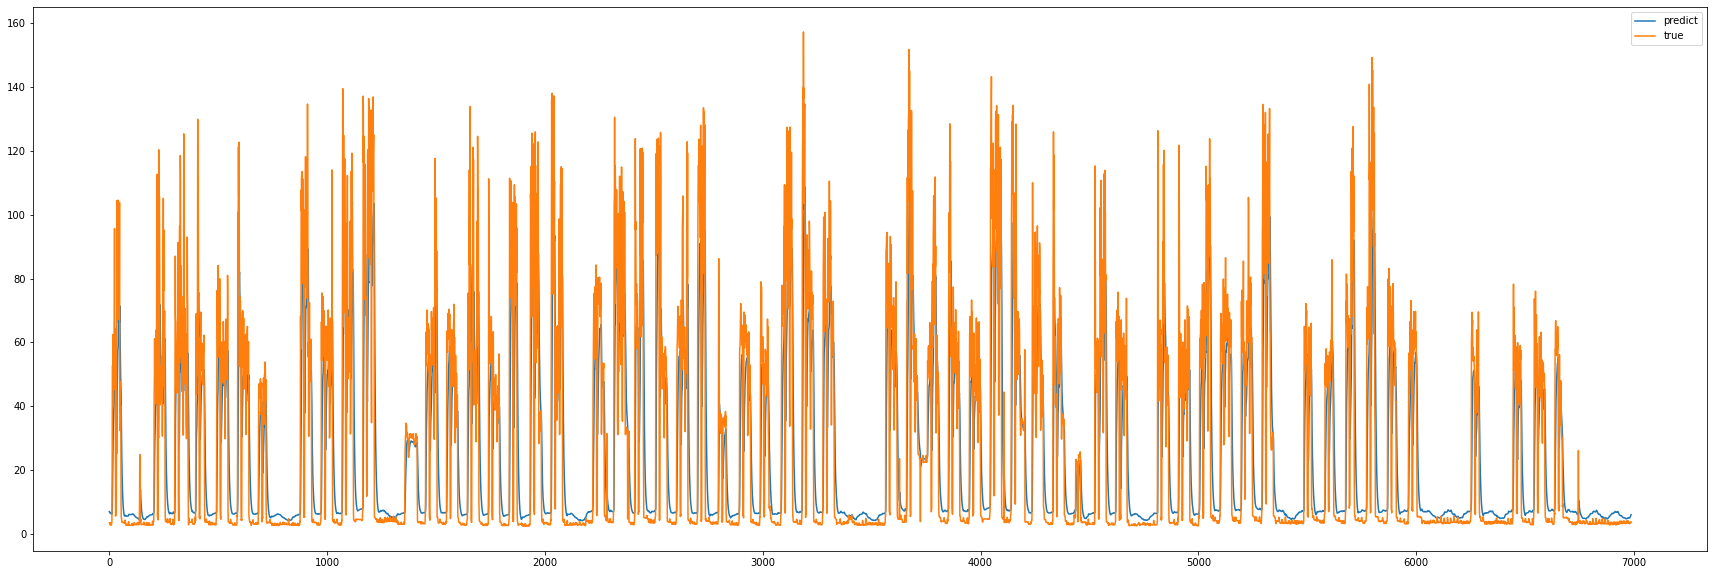

In [13]:
from visualization import predict_visualization
predict_visualization(y_test, predict)

## Modelling LSTM

In [14]:
from model import LSTM_Model


model = LSTM_Model(12, 20)
model.optim = Adam()
setup_optimizers(model)


epoch_num = 10000
learning_rate = 1e-2
trainer(x_train, y_train, x_val, y_val, epoch_num, learning_rate, model)

Epoch 0:  Train loss: 1972.98878  Val loss: 1452.93015
Epoch 25:  Train loss: 1862.27357  Val loss: 1363.13253
Epoch 50:  Train loss: 1672.38421  Val loss: 1214.32736
Epoch 75:  Train loss: 1488.70629  Val loss: 1081.07403
Epoch 100:  Train loss: 1294.31583  Val loss: 922.40941
Epoch 125:  Train loss: 1136.49202  Val loss: 802.68030
Epoch 150:  Train loss: 1003.40562  Val loss: 702.78313
Epoch 175:  Train loss: 890.72244  Val loss: 618.56809
Epoch 200:  Train loss: 793.53577  Val loss: 546.94550
Epoch 225:  Train loss: 713.00805  Val loss: 488.07281
Epoch 250:  Train loss: 642.64119  Val loss: 436.74081
Epoch 275:  Train loss: 581.72154  Val loss: 393.42956
Epoch 300:  Train loss: 530.06923  Val loss: 357.39502
Epoch 325:  Train loss: 486.50876  Val loss: 329.33179
Epoch 350:  Train loss: 448.60989  Val loss: 302.22149
Epoch 375:  Train loss: 415.28448  Val loss: 281.03355
Epoch 400:  Train loss: 386.94406  Val loss: 263.83569
Epoch 425:  Train loss: 363.47582  Val loss: 249.41558
Epoc

In [15]:
best_model = LSTM_Model(12, 20)
best_model.load_params('best_model_LSTM')
test = cp.array(x_test)
predict = best_model.forward(test)
predict = predict.get()

report(predict, y_test)

                      MAE:                8.163
                      MSE:              188.165
                     MAPE:                1.465


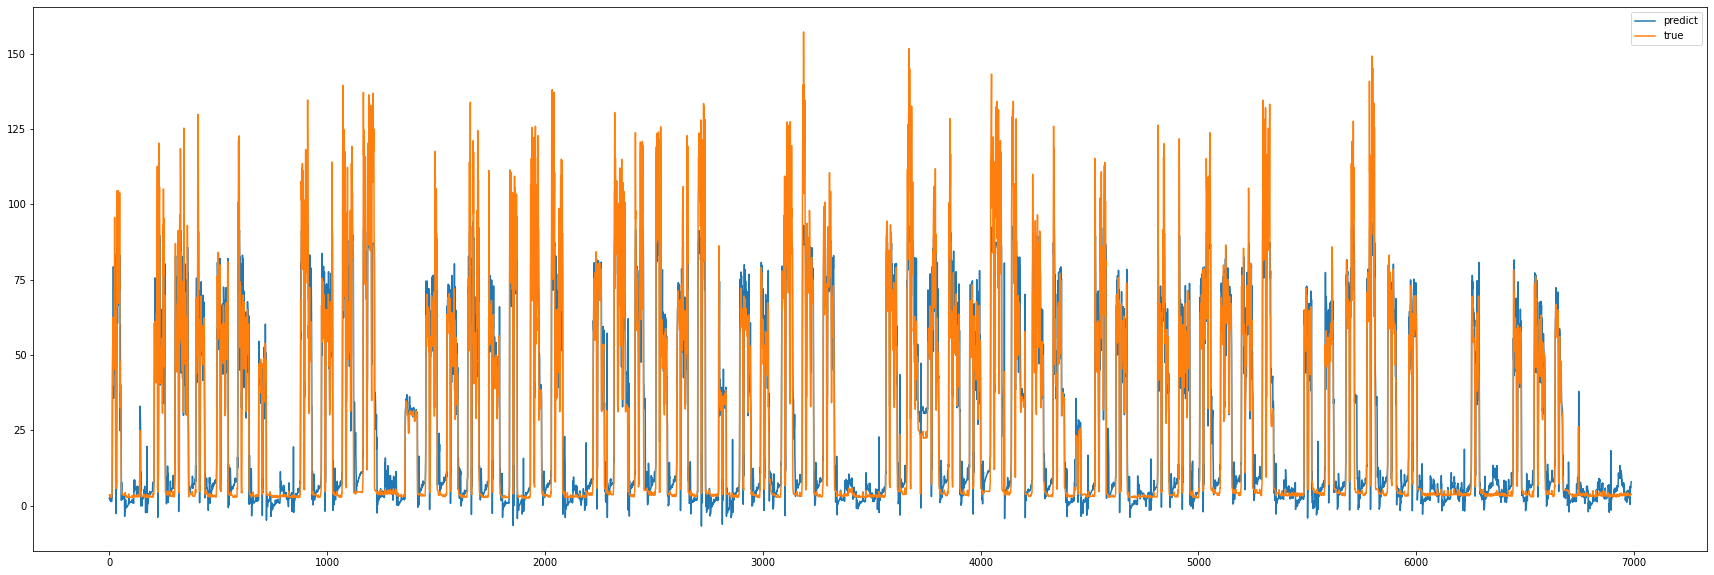

In [18]:
from visualization import predict_visualization
predict_visualization(y_test, predict)

# Results

По метрикам лучше всего себя показал LSTM